## 1.  Custom Loss Function

## Points to note before creating custom loss:

* Need to store the thresholds while saving & using the h5 models again with custom loss

* In such cases use subclass method compared to simpler way of pythonic functions

When you want to define a custom loss function, in general you can just implement
it as a regular Python function. However, if your custom loss function must
support some hyperparameters (or any other state), then you should subclass the
keras.losses.Loss class and implement the __init__() and call() methods. If
you want the loss function’s hyperparameters to be saved along with the model,
then you must also implement the get_config() method.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.boston_housing.load_data()
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
xtrain, xval = xtrain[:350], xtrain[350:]
ytrain, yval = ytrain[:350], ytrain[350:]

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [13]),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1),
    ])
model.compile(loss = 'mae', metrics = ['mae'], optimizer = 'Adam')
history = model.fit(xtrain, ytrain, epochs = 100, validation_data = (xval, yval))

Train on 350 samples, validate on 54 samples
Epoch 1/100
350/350 [==============================] - 1s 3ms/sample - loss: 22.9246 - mae: 22.9246 - val_loss: 22.9132 - val_mae: 22.9132
Epoch 2/100
350/350 [==============================] - 0s 107us/sample - loss: 22.7778 - mae: 22.7778 - val_loss: 22.7652 - val_mae: 22.7652
Epoch 3/100
350/350 [==============================] - 0s 179us/sample - loss: 22.6288 - mae: 22.6288 - val_loss: 22.6172 - val_mae: 22.6172
Epoch 4/100
350/350 [==============================] - 0s 129us/sample - loss: 22.4821 - mae: 22.4821 - val_loss: 22.4643 - val_mae: 22.4643
Epoch 5/100
350/350 [==============================] - 0s 136us/sample - loss: 22.3290 - mae: 22.3290 - val_loss: 22.3087 - val_mae: 22.3087
Epoch 6/100
350/350 [==============================] - 0s 143us/sample - loss: 22.1711 - mae: 22.1711 - val_loss: 22.1543 - val_mae: 22.1543
Epoch 7/100
350/350 [==============================] - 0s 136us/sample - loss: 22.0143 - mae: 22.0143 - val_los

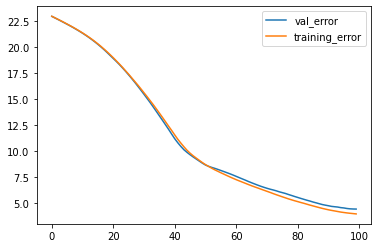

In [4]:
plt.plot(np.arange(100), history.history["val_mae"], label = 'val_error')
plt.plot(np.arange(100), history.history["mae"], label = 'training_error')
plt.legend()

In [5]:
model.evaluate(xtest, ytest)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[4.844916025797526, 4.844916]

In [6]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold = 1.0, **kwargs):
        ''' takes into account of standard hyperparms, std aggregation of loss (sum_over_batch_size)'''
        self.threshold = threshold
        super().__init__(**kwargs)
    
    def call(self, y_true, y_pred):
        ''' compute loss and returns '''
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_error = tf.square(error)/2
        linear_error = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_error, linear_error)

    def get_config(self):
        ''' returns hyperparams name to its value '''
        base_config = super().get_config()
        return {**base_config, 'threshold' : self.threshold}

In [7]:
model.compile(loss = HuberLoss(2.), optimizer = 'Adam')
history = model.fit(xtrain, ytrain, epochs = 100, validation_data = (xval, yval))

Train on 350 samples, validate on 54 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/sample - loss: 6.0858 - val_loss: 6.9552
Epoch 2/100
350/350 [==============================] - 0s 100us/sample - loss: 6.0024 - val_loss: 6.8352
Epoch 3/100
350/350 [==============================] - 0s 114us/sample - loss: 5.9508 - val_loss: 6.7095
Epoch 4/100
350/350 [==============================] - 0s 107us/sample - loss: 5.8871 - val_loss: 6.6391
Epoch 5/100
350/350 [==============================] - 0s 121us/sample - loss: 5.8402 - val_loss: 6.5558
Epoch 6/100
350/350 [==============================] - 0s 121us/sample - loss: 5.7925 - val_loss: 6.5339
Epoch 7/100
350/350 [==============================] - 0s 121us/sample - loss: 5.7537 - val_loss: 6.5056
Epoch 8/100
350/350 [==============================] - 0s 143us/sample - loss: 5.7101 - val_loss: 6.4410
Epoch 9/100
350/350 [==============================] - 0s 150us/sample - loss: 5.6741 - val_loss: 6.3889
Epoch 10/100

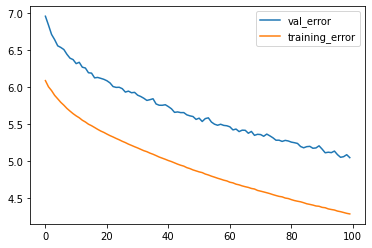

In [8]:
plt.plot(np.arange(100), history.history["val_loss"], label = 'val_error')
plt.plot(np.arange(100), history.history["loss"], label = 'training_error')
plt.legend()

In [9]:
model.evaluate(xtest, ytest)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

5.624005691677916

In [10]:
## Saving Model
tf.keras.models.save_model(model, "my_model_custom_loss_class.h5")

In [12]:
# model.compile(loss = HuberLoss(2.), optimizer = 'Adam')
model_from_saved = tf.keras.models.load_model("my_model_custom_loss_class.h5", custom_objects={'HuberLoss' : HuberLoss()}, compile=False)

In [13]:
model_from_saved.compile(loss = HuberLoss(2.), optimizer = 'Adam')

model_from_saved.evaluate(xtest, ytest)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

5.624005691677916

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name='3_layer_mlp')

# Useless custom loss here
def custom_loss(y_true, y_pred):
    return keras.backend.mean(keras.backend.square(y_true - y_pred), axis=-1)

model.save("model", save_format='tf')
model.compile(loss=custom_loss, optimizer=keras.optimizers.RMSprop())
# Here comes the bug (no bug)
new_model = keras.models.load_model('model', custom_objects={'loss': custom_loss})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model\assets


### 2. Custom Activations, Regularizers, Initializers

#### Points to note:
* Use always tf functionality to maximise the performance

* you must implement the call() method for losses, layers (including activation
functions), and models, or the __call__() method for regularizers, initializers,
and constraints.

In [15]:
def softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def glorot_initializer(shape, dtype = tf.float32):
    stddev = tf.sqrt(2./(shape[0] + shape[1]))
    return tf.random.normal(shape, mean=0, stddev=stddev, dtype=dtype)

def l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.1 * weights))

def relu_constraint(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [16]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.boston_housing.load_data()
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
xtrain, xval = xtrain[:350], xtrain[350:]
ytrain, yval = ytrain[:350], ytrain[350:]

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [13]),
    tf.keras.layers.Dense(10, activation=softplus, kernel_initializer=glorot_initializer,
                         kernel_regularizer=l1_regularizer, kernel_constraint=relu_constraint),
    tf.keras.layers.Dense(1),
    ])
model.compile(loss = 'mae', metrics = ['mae'], optimizer = 'Adam')
history = model.fit(xtrain, ytrain, epochs = 100, validation_data = (xval, yval))

Train on 350 samples, validate on 54 samples
Epoch 1/100
350/350 [==============================] - 1s 3ms/sample - loss: 24.8398 - mae: 23.3067 - val_loss: 24.6270 - val_mae: 23.2804
Epoch 2/100
350/350 [==============================] - 0s 136us/sample - loss: 24.5005 - mae: 23.1802 - val_loss: 24.4516 - val_mae: 23.1624
Epoch 3/100
350/350 [==============================] - 0s 136us/sample - loss: 24.3205 - mae: 23.0570 - val_loss: 24.2775 - val_mae: 23.0449
Epoch 4/100
350/350 [==============================] - 0s 129us/sample - loss: 24.1419 - mae: 22.9349 - val_loss: 24.1043 - val_mae: 22.9283
Epoch 5/100
350/350 [==============================] - 0s 136us/sample - loss: 23.9659 - mae: 22.8153 - val_loss: 23.9318 - val_mae: 22.8118
Epoch 6/100
350/350 [==============================] - 0s 129us/sample - loss: 23.7910 - mae: 22.6957 - val_loss: 23.7619 - val_mae: 22.6965
Epoch 7/100
350/350 [==============================] - 0s 129us/sample - loss: 23.6183 - mae: 22.5774 - val_los

In [18]:
## Use subclass approach if you want to save l1 regularizer factor along with model
class l1_regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor, **kwargs):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {'factor' : self.factor}

### Custom Metrics

Much like custom loss functions, most metrics can be defined as regular Python
functions. But if you want your custom metric to support some hyperparameters
(or any other state), then you should subclass the keras.metrics.Metric class.
Moreover, if computing the metric over a whole epoch is not equivalent to computing
the mean metric over all batches in that epoch (e.g., as for the precision
and recall metrics), then you should subclass the keras.metrics.Metric class
and implement the __init__(), update_state(), and result() methods to keep
track of a running metric during each epoch. You should also implement the
reset_states() method unless all it needs to do is reset all variables to 0.0. If
you want the state to be saved along with the model, then you should implement
the get_config() method as well.

### 3. Custom Layers


In [19]:
## this layer creates exponential of inputs
exponential_layer = tf.keras.layers.Lambda(lambda x : tf.exp(x))

In [20]:
## Custom Dense Layer

class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation = None, **kwargs):
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name = "kernel", shape = [batch_input_shape[-1], self.units], initializer='glorot_normal')
        self.bias = self.add_weight(name = 'bias', shape = [self.units], initializer= "zeros")
        super().build(batch_input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units" : self.units, 
    "activations" : tf.keras.activations.serialize(self.activation)}

### 4. AutoDiff

In [29]:
## Math Differentiation way
w1, w2 = 5, 3
eps = 1e-6
def f(w1, w2):
    return 3*w1**2 + 2*w1*w2

print(f"Gradient of w1 : {(f(w1 + eps, w2) - f(w1, w2))/(1*eps)}")
print(f"Gradient of w2 : {(f(w1, w2 + eps) - f(w1, w2))/(1*eps)}")

Gradient of w1 : 36.000003007075065
Gradient of w2 : 10.000000003174137


In [36]:
## Using Auto Diff
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: id=16208, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=16200, shape=(), dtype=float32, numpy=10.0>]

In [38]:
## Auto diff erase grad calls immediately
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
tape.gradient(z, w1) # This will work
tape.gradient(z, w2)  # this will print error

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

In [39]:
## Auto diff erase grad calls immediately : Use persistance
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)
tape.gradient(z, w1) # This will work
tape.gradient(z, w2)  # this will print error

<tf.Tensor: id=16327, shape=(), dtype=float32, numpy=10.0>

In [42]:
## Making gradient watch manually any variable of interest
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    tape.watch(w1)
    tape.watch(w2)
    z = f(w1, w2)
tape.gradient(z, [w1, w2]) # This will work

[<tf.Tensor: id=16428, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=16420, shape=(), dtype=float32, numpy=10.0>]

In [46]:
## Stoping Gradients

w1, w2 = tf.Variable(5.), tf.Variable(3.)
def f(w1, w2):
    return tf.stop_gradient(3*w1**2) + 2*w2

with tf.GradientTape() as tape:
    z = f(w1, w2)
tape.gradient(z, [w1, w2]) # This will work

[None, <tf.Tensor: id=16558, shape=(), dtype=float32, numpy=2.0>]

In [49]:
## NaN Gradients
w1 = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = softplus(w1)
tape.gradient(z, w1)

## Avoiding NaN through analytical custom loss function
@tf.custom_gradient
def better_softplus(z):
    exp = tf.exp(z)
    def softplus_gradient(grad):
        return grad/(1 + 1/exp)
    return tf.math.log(exp + 1), softplus_gradient

w1 = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = better_softplus(w1)
tape.gradient(z, w1)

<tf.Tensor: id=16619, shape=(), dtype=float32, numpy=1.0>

### Graphs

In [2]:
import tensorflow as tf
@tf.function
def sum_squares(n):
    s = 0
    for i in range(n+1):
        s += i**2
    return s

In [5]:
sum_squares(3)

<tf.Tensor: id=12, shape=(), dtype=int32, numpy=14>

In [6]:
tf.autograph.to_code(sum_squares.python_function)

"def tf__sum_squares(n):\n  do_return = False\n  retval_ = ag__.UndefinedReturnValue()\n  with ag__.FunctionScope('sum_squares', 'sum_squares_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as sum_squares_scope:\n    s = 0\n\n    def get_state():\n      return ()\n\n    def set_state(_):\n      pass\n\n    def loop_body(iterates, s):\n      i = iterates\n      s += i ** 2\n      return s,\n    s, = ag__.for_stmt(ag__.converted_call(range, sum_squares_scope.callopts, (n + 1,), None, sum_squares_scope), None, loop_body, get_state, set_state, (s,), ('s',), ())\n    do_return = True\n    retval_ = sum_squares_scope.mark_return_value(s)\n  do_return,\n  return ag__.retval(retval_)\n"

## Exercise

### Create BatchNorm Layer


In [23]:
class myBatchNorm(tf.keras.layers.Layer):
    def __init__(self, eps = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape, dtype = tf.float32):
        self.alpha = self.add_weight(name = 'alpha', shape = batch_input_shape[-1:], initializer = "ones")
        self.beta = self.add_weight(name = 'beta', shape = batch_input_shape[-1:], initializer = "zeros")
        super().build(batch_input_shape)
    
    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha*(X - mean)/(tf.sqrt(variance + self.eps)) + self.beta
        # return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps" : self.eps}

In [25]:
X = tf.cast(tf.Variable(tf.range(10)), tf.float32)
custom_norm = myBatchNorm()
keras_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.mean_absolute_error(custom_norm(X), keras_norm(X)))

<tf.Tensor: id=392, shape=(), dtype=float32, numpy=5.364418e-08>